__Instruction: Just run from top to bottom. Because of time constraint, hyperparameters were not explored.__

In [112]:
import pandas as pd
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

### Part 1: Overview

In [113]:
#Example of a record in the dataset
df = pd.read_csv('Tweets.csv')
df.head(1)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,NaN,Eastern Time (US & Canada)


In [114]:
#Feature overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  float64
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### Part 2: Exploratory visualizations

Text(0.5, 1.0, 'United has the most reviews in the dataset, while Virgin America has the least')

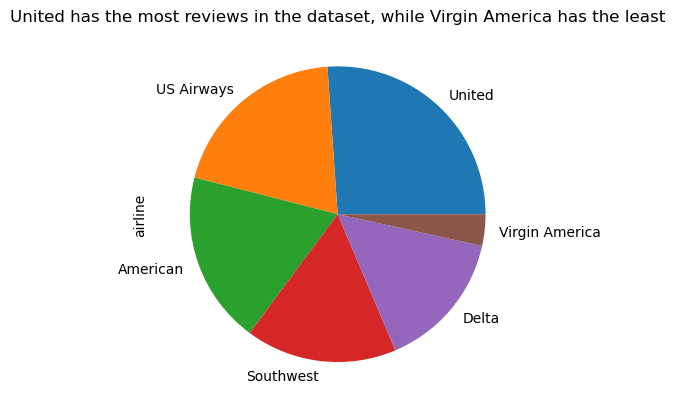

In [115]:
#1. A rough distribution of the number of reviews in the dataset
df.airline.value_counts().plot(kind='pie')
plt.title('United has the most reviews in the dataset, while Virgin America has the least')

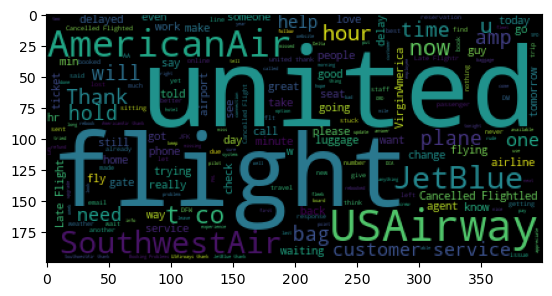

In [116]:
#2. word cloud
words = ''.join(df['text'])
wc = WordCloud().generate(words)
plt.imshow(wc)

It is clear that the airline names most frequently appear in the dataset, while terms like 'customer service', 'delayed', 'cancelled' happen often as well.

<BarContainer object of 10 artists>

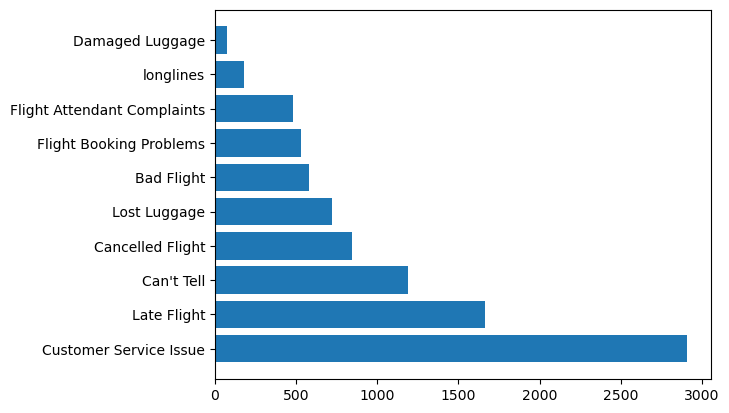

In [117]:
#3. most common bad review reasons
plt.barh(df['negativereason'].value_counts().index, df['negativereason'].value_counts().values)

It is clear that customer service issue is the biggest reason for negative airline reviews

### Part 3: Pre-processing for sentiment analysis

In [118]:
#drop columns with too many null values, and the irrelavant columns
df_filtered = df[['airline_sentiment', 'text']].drop_duplicates()


I understand that those other fields could be really useful, but I'd like to keep the scope small and focus on sentiment analysis.

In [119]:
df_filtered

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [120]:
#print a sample of reviews
review_all = list(df_filtered['text'])
review_all[:10]

['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica plus you've added commercials to the experience... tacky.",
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it",
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP',
 "@virginamerica Well, I didn't…but NOW I DO! :-D",
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."]

From a rough inspection from a sample of reviews, we can see that the review text starts with @airline name, this word will be removed in the next step. The http links and emojis should also be removed.

In [121]:
#clean each review
import re
review_cleaned = []
for review in review_all:
    
    #1. remove links
    review = re.compile(r'https?://\S+|www\.\S+').sub('', review)
    
    #2. remove emojis
    #referenced from https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030""]+", re.UNICODE)
    
    review = emoji_pattern.sub(' ', review)
    
    #3. remove usernames and airline names and convert to lower case
    review = re.sub('@[^\s]+','',review).lower()
    
    #4. remove all hashtags
    review = re.sub('#[^\s]+','',review)
    
    #5. remove all punctuations
    review = re.sub(r'[^\w\s]', ' ', review)
    
    #6. remove all stopwords
    review = ' '.join([word for word in review.split() if word not in stopwords])
    
    #7. remove all numbers
    review = re.sub(r'\d', ' ', review)
    
    review_cleaned.append(review)
       
review_cleaned[1:8]

['plus added commercials experience tacky',
 'today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guests faces amp little recourse',
 'really big bad thing',
 'seriously would pay    flight seats playing really bad thing flying va',
 'yes nearly every time fly vx ear worm go away',
 'really missed prime opportunity men without hats parody']

This is not perfect, but a lot better than the uncleaned version.

In [122]:
#verify the length of X and y
X = review_cleaned
y = df_filtered['airline_sentiment']
print(len(X), len(y))

14452 14452


In [123]:
#selected this vectorizer as we learned that in class
from sklearn.feature_extraction.text import TfidfVectorizer
X_vectorized = TfidfVectorizer().fit_transform(X)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

### Part 4: Supervised Classification

In [125]:
#1. K-Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3).fit(X_train,y_train)
knn_pred = knn.predict(X_test)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

    negative       0.68      0.96      0.80      1800
     neutral       0.58      0.19      0.28       611
    positive       0.70      0.21      0.33       480

    accuracy                           0.67      2891
   macro avg       0.65      0.45      0.47      2891
weighted avg       0.66      0.67      0.61      2891



In [126]:
#2. Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 300).fit(X_train,y_train) # set 300 as a lower number of iterations failed to converge
lr_pred = lr.predict(X_test)
print(classification_report(y_test,lr_pred))

              precision    recall  f1-score   support

    negative       0.77      0.94      0.85      1800
     neutral       0.65      0.42      0.51       611
    positive       0.81      0.52      0.63       480

    accuracy                           0.76      2891
   macro avg       0.74      0.63      0.66      2891
weighted avg       0.75      0.76      0.74      2891



In [127]:
#3. Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier().fit(X_train,y_train)
dt_pred = dt.predict(X_test)
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

    negative       0.79      0.81      0.80      1800
     neutral       0.48      0.49      0.49       611
    positive       0.60      0.54      0.57       480

    accuracy                           0.70      2891
   macro avg       0.63      0.61      0.62      2891
weighted avg       0.70      0.70      0.70      2891



In [128]:
#4. Support Vector Machine(SVM)
from sklearn.svm import SVC
svm = SVC().fit(X_train,y_train)
svm_pred = svm.predict(X_test)
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

    negative       0.75      0.96      0.84      1800
     neutral       0.72      0.33      0.45       611
    positive       0.81      0.51      0.63       480

    accuracy                           0.75      2891
   macro avg       0.76      0.60      0.64      2891
weighted avg       0.75      0.75      0.72      2891



In [129]:
#5. Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

    negative       0.78      0.92      0.84      1800
     neutral       0.64      0.44      0.52       611
    positive       0.72      0.49      0.58       480

    accuracy                           0.75      2891
   macro avg       0.71      0.62      0.65      2891
weighted avg       0.74      0.75      0.73      2891



### Part 5: Model Comparison

<BarContainer object of 5 artists>

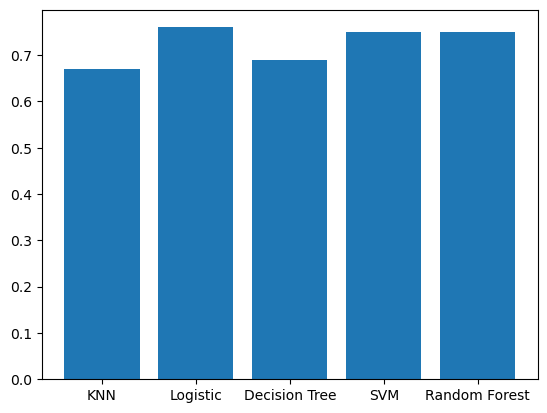

In [130]:
#1. compare accuracy
methods = ['KNN', 'Logistic', 'Decision Tree', 'SVM', 'Random Forest']
acc = [0.67, 0.76, 0.69, 0.75, 0.75]
plt.bar(methods, acc)

The accuracy of the models are relatively close, ranging from 0.67 to 0.75

<BarContainer object of 5 artists>

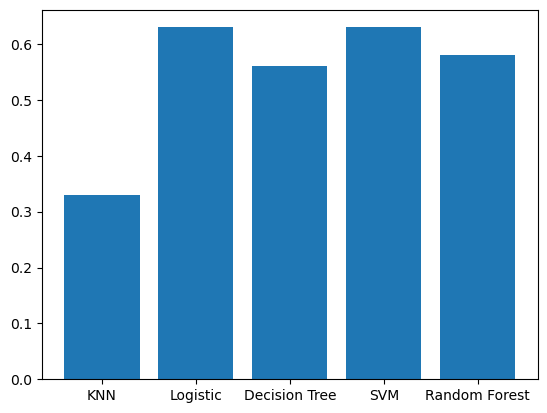

In [131]:
#2. compare f1 score for positive reviews
f1_pos = [0.33, 0.63, 0.56, 0.63, 0.58]
plt.bar(methods, f1_pos)

In terms of the F1 score to predict positive reviews, we can see that K-nearest neighbors performs significantly worse than other models.

<BarContainer object of 5 artists>

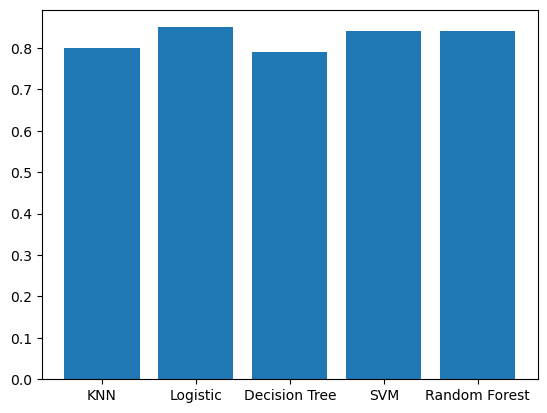

In [132]:
#3. compare f1 score for negative reviews
f1_neg = [0.80, 0.85, 0.79, 0.84, 0.84]
plt.bar(methods, f1_neg)

The F1 score to predict negative reviews of the models are relatively close, ranging from 0.79 to 0.85. However, it performs significantly better than predicting positive reviews.